# Combining Models

Now we might want to combine different models together. For example, we might want to fit a transit simultaneously with its systematics (polynomials in time, x, y, background etc.). This is very similar to the Transit and Polynomial tutorials, so if you haven't looked at those tutorials I recommend you do before this one!

In [1]:
# import chromatic_fitting of course!
from chromatic_fitting import *

# import any prior distributions we want to use for our parameters - I've chosen Normal and Uniform from pymc3
# and QuadLimbDark and ImpactParameter from exoplanet
from pymc3 import Normal, Uniform
from exoplanet import QuadLimbDark, ImpactParameter

# import astropy table just for this tutorial (pandas dataframes don't show up nicely on the docs pages!)
from astropy.table import Table

plt.matplotlib.style.use('default')

Running chromatic_fitting v0.11.0!

This program is running on:
Python v3.9.12 (main, Jun  1 2022, 06:34:44) 
[Clang 12.0.0 ]
numpy v1.22.1
chromatic v0.4.5
pymc3 v3.11.5
pymc3_ext v0.1.1
exoplanet v0.5.2


Generate some simulated data. This time we will use the handy `.inject_systematics()` and `.inject_noise()` functions in `chromatic`

  0%|          | 0/231 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

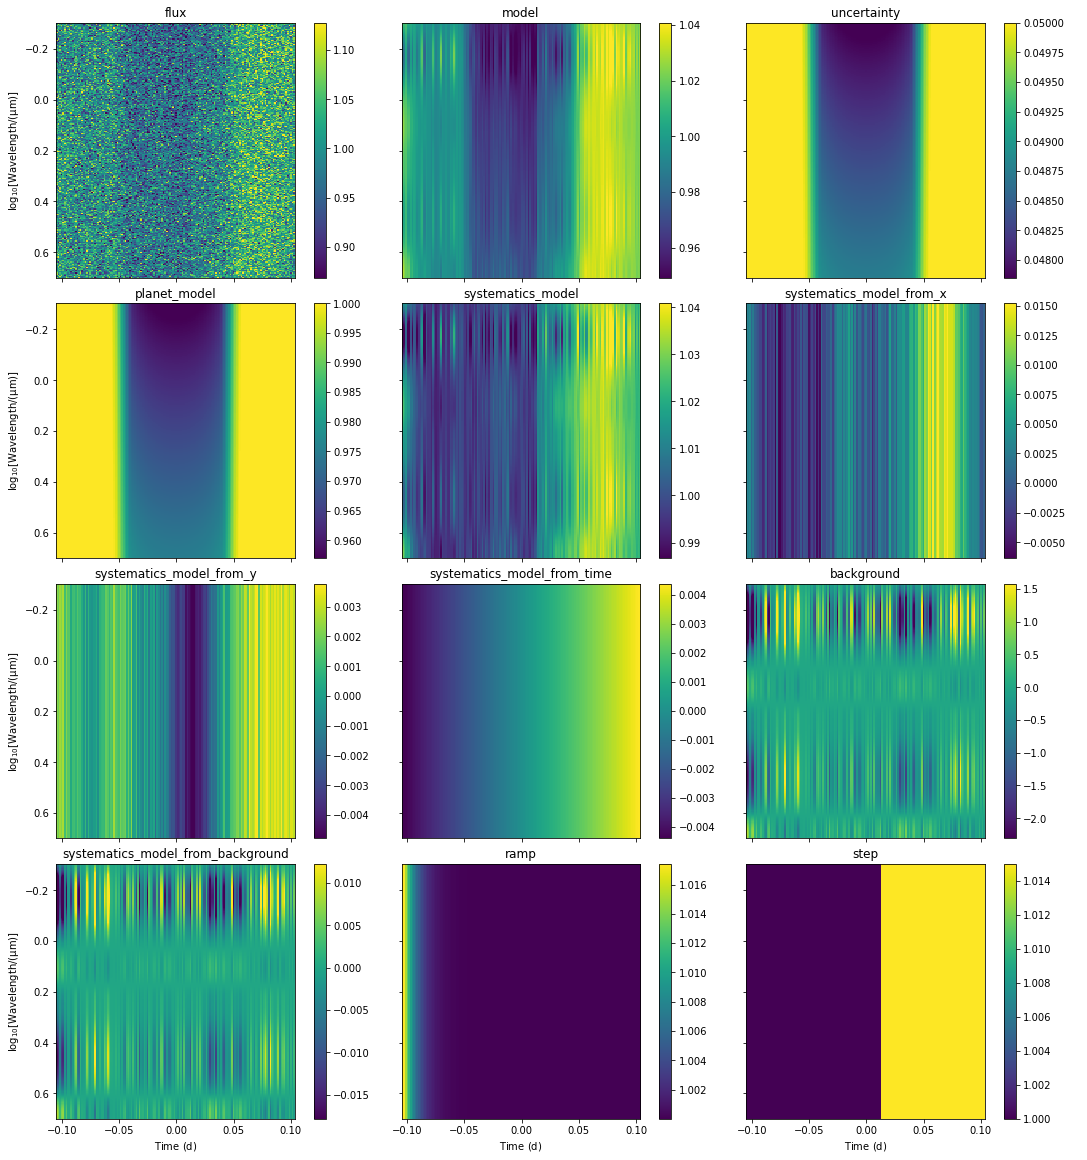

In [2]:
# create a basic simulated data set
s = SimulatedRainbow()
# inject a transit and noise as well as systematics in x, y, background and time.
s = s.inject_transit(planet_radius=np.linspace(0.2, 0.15, s.nwave)).inject_noise(signal_to_noise=20).inject_systematics(amplitude=0.005)

ramp = np.array([np.ones(s.ntime)] * s.nwave)
A = 0.02
decay_time = 0.01
C = 1
ramp = A * np.exp(-(s.time.to_value('d')-s.time[0].to_value('d'))/decay_time) + C
s.flux = s.flux * ramp
s.fluxlike['model'] = s.fluxlike['model'] * ramp
s.fluxlike['systematics_model'] = s.fluxlike['systematics_model']*ramp
s.fluxlike['ramp'] = np.array([ramp]*s.nwave)

step = np.array([np.ones(s.ntime)] * s.nwave)
step[:,85:] *= 1.015
s.flux = s.flux * step
s.fluxlike['model'] = s.fluxlike['model']*step
s.fluxlike['systematics_model'] = s.fluxlike['systematics_model']*step
s.fluxlike['step'] = step

# show all the Rainbow.fluxlike quantities:
s.imshow_quantities();
# finally, we will bin our lightcurves to make this tutorial run faster!
nwave = 6
sb = s.bin(nwavelengths=int(s.nwave/nwave), dt=5 * u.minute)

<AxesSubplot:xlabel='Time ($\\mathrm{d}$)', ylabel='log$_{10}$[Wavelength/($\\mathrm{\\mu m}$)]'>

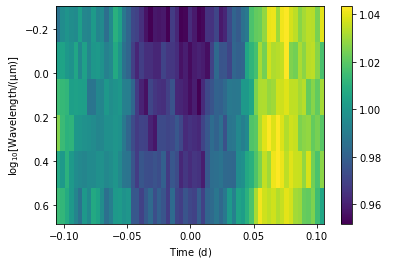

In [3]:
sb.imshow()

  0%|          | 0/150 [00:00<?, ?it/s]

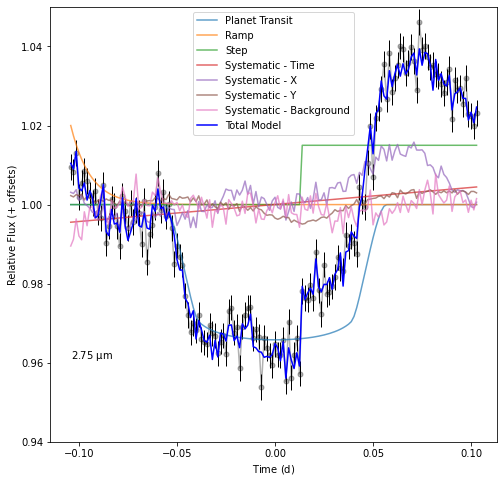

In [4]:
fig,ax = plt.subplots(figsize=(8,8))
sb2 = s.bin(nwavelengths=s.nwave)#, dt=4 * u.minute)
# sb2=s
sb2.plot_lightcurves(ax=ax,cmap='gray', plotkw={'alpha':0.3})
plt.ylim(0.94,1.05)
plt.plot(sb2.time, sb2.fluxlike['planet_model'][0], label='Planet Transit', alpha=0.7)
plt.plot(sb2.time, sb2.fluxlike['ramp'][0], label='Ramp', alpha=0.7)
plt.plot(sb2.time, sb2.fluxlike['step'][0], label='Step', alpha=0.7)
plt.plot(sb2.time, 1+sb2.fluxlike['systematics_model_from_time'][0], label='Systematic - Time', alpha=0.7)
plt.plot(sb2.time, 1+sb2.fluxlike['systematics_model_from_x'][0], label='Systematic - X', alpha=0.7)
plt.plot(sb2.time, 1+sb2.fluxlike['systematics_model_from_y'][0], label='Systematic - Y', alpha=0.7)
plt.plot(sb2.time, 1+sb2.fluxlike['systematics_model_from_background'][0], label='Systematic - Background', alpha=0.7)
plt.plot(sb2.time, sb2.fluxlike['planet_model'][0] * \
         (sb2.fluxlike['ramp'][0] + sb2.fluxlike['systematics_model_from_time'][0] + sb2.fluxlike['systematics_model_from_x'][0] + sb2.fluxlike['systematics_model_from_y'][0] + sb2.fluxlike['systematics_model_from_background'][0]) * \
         sb2.fluxlike['step'][0], label='Total Model', c='blue')
# plt.plot(sb2.time, sb2.fluxlike['model'][0], label='Total Model')
# plt.plot(sb2.time)
plt.legend();

In [5]:
sb2.fluxlike.keys()
# s.flu/xlike.keys()
# np.shape(ramp)

dict_keys(['flux', 'model', 'uncertainty', 'planet_model', 'systematics_model', 'systematics_model_from_x', 'systematics_model_from_y', 'systematics_model_from_time', 'background', 'systematics_model_from_background', 'ramp', 'step'])

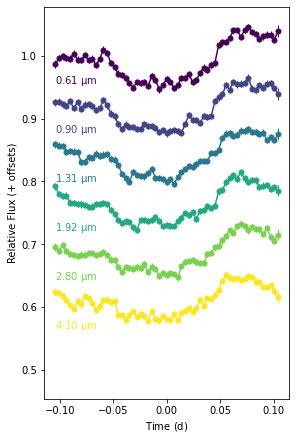

In [6]:
sb.plot_lightcurves();

Set up the transit and polynomial models. This is where we can set the distributions for every parameter, the names of the models, the degree of the polynomials, the variables we want to relate the polynomials to, etc. Here we decided to just model linear polynomials (with degree=1) for each systematic variable: 

In [7]:
# set up transit model:
t = TransitModel()
t.setup_parameters(
                  period=1,
                   epoch=Fitted(Uniform,lower=-0.05,upper=0.05),
                   stellar_radius = Fitted(Uniform, lower=0.8, upper=1.2,testval=1),
                   stellar_mass =Fitted(Uniform, lower=0.8, upper=1.2,testval=1),
                   radius_ratio=WavelikeFitted(Normal, mu=0.1, sigma=0.05),
                   impact_parameter=Fitted(ImpactParameter,ror=0.15,testval=0.44),
                   limb_darkening=WavelikeFitted(Uniform,testval=[0.05,0.35],shape=2),
                    baseline = WavelikeFitted(Normal, mu=1.0, sigma=0.1)
                )

# set up time polynomial model:
b = PolynomialModel(degree=1, name='stime')
b.setup_parameters(
    p_0 = 1.0,
    p_1 = Fitted(Normal,mu=0.0,sigma=0.01),
)

# set up x polynomial model:
b_x = PolynomialModel(degree=1, independant_variable="x", name='sx')
b_x.setup_parameters(
    p_1 = Fitted(Normal,mu=0.0,sigma=0.01),
)

# set up y polynomial model:
b_y = PolynomialModel(degree=1, independant_variable="y", name='sy')
b_y.setup_parameters(
    p_1 = Fitted(Normal,mu=0.0,sigma=0.01),
)

# set up bkg polynomial model:
b_bkg = PolynomialModel(degree=1, independant_variable="background", name='sbkg')
b_bkg.setup_parameters(
    p_1 = Fitted(Normal,mu=0.0,sigma=0.01),
)

# add ramp model:
ramp = ExponentialModel(t0=s.time[0])
ramp.setup_parameters(
    A = Fitted(Uniform,testval=0.01,upper=0.05,lower=-0.05),
    decay_time = Fitted(Uniform,testval=0.001,upper=0.01,lower=0),
    baseline = 0
)

# add step model:
step = StepModel()
step.setup_parameters(
    df=Fitted(Uniform, lower=0.0, upper=0.03),
    f0=1,
    t0=Fitted(Uniform, lower=0.0, upper=0.03)
)

We can combine the models by using the standard arithmetic operators: +, -, * and /. In this case I will multiply the transit model by the sum of all the systematic polynomials. *Note: we have to be careful here not to have multiple different variables that all describe some constant offset.* For example, in the transit model we have the 'baseline' parameter that determines the out-of-transit constant flux. But in the polynomials we can also fit for the 0th order flux, 'p_0'. We should be careful not to fit for both! (By default 'p_0' will be set to 0.0 in the models where we don't define it.)

In [8]:
cmod = t * step * (b + b_x + b_y + b_bkg + ramp)
cmod

/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:208: UserWarning: transit in the parameter name: transit_stellar_radius. Please avoid having the model name in the parameter name as it can get confusing!
  warnings.warn(
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:208: UserWarning: step in the parameter name: step_df. Please avoid having the model name in the parameter name as it can get confusing!
  warnings.warn(
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:208: UserWarning: stime in the parameter name: stime_p_0. Please avoid having the model name in the parameter name as it can get confusing!
  warnings.warn(
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:208: UserWarning: sx in the parameter nam

<chromatic combined model 'combined' 🌈, models: <chromatic polynomial model 'stime' 🌈> * <chromatic polynomial model 'sx' 🌈> + <chromatic polynomial model 'sy' 🌈> + <chromatic polynomial model 'sbkg' 🌈> + <chromatic exponential model 'exponential' 🌈> + <chromatic transit model 'transit' 🌈> * <chromatic step model 'step' 🌈>

The individual models will be stored in a dictionary under `.chromatic_models`:

In [9]:
cmod._chromatic_models

{'stime': <chromatic polynomial model 'stime' 🌈>,
 'sx': <chromatic polynomial model 'sx' 🌈>,
 'sy': <chromatic polynomial model 'sy' 🌈>,
 'sbkg': <chromatic polynomial model 'sbkg' 🌈>,
 'exponential': <chromatic exponential model 'exponential' 🌈>,
 'transit': <chromatic transit model 'transit' 🌈>,
 'step': <chromatic step model 'step' 🌈>}

Let's see what parameters we have in our models:

In [10]:
cmod.summarize_parameters()

A CombinedModel itself does not have any parameters, however each of its constituent models do:

stime_p_0 =
  <🧮 Fixed | 1.0 🧮>

stime_p_1 =
  <🧮 Fitted Normal(mu=0.0, sigma=0.01, name='stime_p_1') 🧮>

sx_p_0 =
  <🧮 Fixed | 0.0 🧮>

sx_p_1 =
  <🧮 Fitted Normal(mu=0.0, sigma=0.01, name='sx_p_1') 🧮>

sy_p_0 =
  <🧮 Fixed | 0.0 🧮>

sy_p_1 =
  <🧮 Fitted Normal(mu=0.0, sigma=0.01, name='sy_p_1') 🧮>

sbkg_p_0 =
  <🧮 Fixed | 0.0 🧮>

sbkg_p_1 =
  <🧮 Fitted Normal(mu=0.0, sigma=0.01, name='sbkg_p_1') 🧮>

exponential_A =
  <🧮 Fitted Uniform(testval=0.01, upper=0.05, lower=-0.05, name='exponential_A') 🧮>

exponential_decay_time =
  <🧮 Fitted Uniform(testval=0.001, upper=0.01, lower=0, name='exponential_decay_time') 🧮>

exponential_baseline =
  <🧮 Fixed | 0 🧮>

transit_stellar_radius =
  <🧮 Fitted Uniform(lower=0.8, upper=1.2, testval=1, name='transit_stellar_radius') 🧮>

transit_stellar_mass =
  <🧮 Fitted Uniform(lower=0.8, upper=1.2, testval=1, name='transit_stellar_mass') 🧮>

transit_radius_rati

Then we just attach the Rainbow data to the model and run `.setup_lightcurves()` and `.setup_likelihood()` as in the previous tutorials:

In [11]:
# attach the data to our model
cmod.attach_data(sb)

# If we don't want to fit everything simultaneously we can change the optimization method (the options 
# are "separate" or "white_light"). This has to be set BEFORE running .setup_lightcurves!
cmod.choose_optimization_method('separate')

# The 'store_models' keyword can be useful later to speed up debugging/plotting, but it can slow 
# down/break fitting for large numbers of wavelengths
cmod.setup_lightcurves(normalize=False) # (store_models=True)

# Finally use the observed data to fit the model (assuming Gaussian errors!)
cmod.setup_likelihood()

/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:208: UserWarning: stime in the parameter name: stime_p_0. Please avoid having the model name in the parameter name as it can get confusing!
  warnings.warn(
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:208: UserWarning: sx in the parameter name: sx_p_0. Please avoid having the model name in the parameter name as it can get confusing!
  warnings.warn(
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:208: UserWarning: sy in the parameter name: sy_p_0. Please avoid having the model name in the parameter name as it can get confusing!
  warnings.warn(
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:208: UserWarning: sbkg in the parameter name: sbkg_p_0. Please av

In [12]:
cmod._chromatic_models

{'stime': <chromatic polynomial model 'stime' 🌈>,
 'sx': <chromatic polynomial model 'sx' 🌈>,
 'sy': <chromatic polynomial model 'sy' 🌈>,
 'sbkg': <chromatic polynomial model 'sbkg' 🌈>,
 'exponential': <chromatic exponential model 'exponential' 🌈>,
 'transit': <chromatic transit model 'transit' 🌈>,
 'step': <chromatic step model 'step' 🌈>}

If we look at our `PyMC3` model we can see that it has a lot of parameters (the combination of all our models) to optimize! If we've chosen the separate wavelength fitting method (`.choose_optimization_method("separate")`) then `._pymc3_model` will return a list of PyMC3 models (one for each wavelength).

In [13]:
cmod._pymc3_model

We've got our polynomial parameters (`stime_p_1, sx_p_1, sy_p_1, sbkg_p_1`), our transit parameters that are wavelength-independant in this case (`epoch, impact_parameter, stellar_radius, stellar_mass, a_R*, limb_darkening`) and the wavelength-dependant parameters we've defined to be `radius_ratio_w{N}` only. The `wavelength_{N}_data` parameter just represents the fit of the data to the model at each wavelength (which we've defined to be a Normal distribution). If we've decided to `store_models` then we will also see a bunch of models!

But what do the actual light curves look like?

In [14]:
def plot_lightcurves(self, t_unit="day", ax=None, **kw):
    """
    Plot the 2D lightcurves for each wavelength separated on the same plot

    Parameters
    ----------
    t_unit: Unit for the time series (default="day")
    ax: Axis object to plot onto (default=None)
    kw: Any extra keywords to pass to chromatic.Rainbow.plot()

    Returns
    -------

    """

    data = self.get_data()

    if not hasattr(self, "summary"):
        print(
            "The summarize step has not been run yet. To include the 'best-fit' model please run "
            "{self}.sample() and {self}.summarize() before calling this step!"
        )
        add_model = False
    else:
        if isinstance(self, CombinedModel):
            model = self.get_model()
        else:
            model = {}
            for i in range(data.nwave):
                model[f"w{i}"] = {"total": self.get_model()}
        add_model = True

    # if the user has provided an axis object then use, otherwise create one here
    if ax is None:
        ax = plt.subplot()
    plt.sca(ax)

    # if we've flagged outliers then show these on the plot in red
    if self.outlier_flag:
        data.plot(ax=ax, cmap="Reds", **kw)
        self.data_without_outliers.plot(ax=ax, **kw)
    else:
        data.plot(ax=ax, **kw)

    # get the lightcurve spacing from chromatic
    spacing = ax._most_recent_chromatic_plot_spacing

    # if add_model=True then overplot the fitted model
    if add_model:
        for i in range(data.nwave):
            print(i, model.keys())
            ax.plot(
                data.time.to_value(t_unit),
                np.array(model[f"w{i}"]["total"]) - (i * spacing),
                color="k",
            )

    # if filename is provided then save the plot
    if "filename" not in kw.keys():
        plt.show()
    else:
        plt.savefig(kw["filename"])
    plt.close()

The summarize step has not been run yet. To include the 'best-fit' model please run {self}.sample() and {self}.summarize() before calling this step!


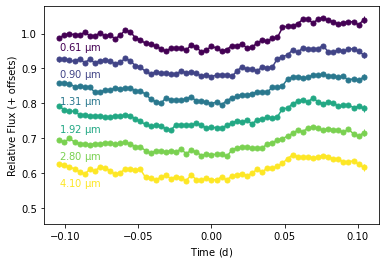

In [15]:
# plot_lightcurves(cmod)
cmod.plot_lightcurves()

We can still see the transit for each wavelength, but it's clear that the systematics would affect any derivation of the transit parameters if we didn't model for these systematics! 

## PyMC3 Sampling

Now we can run the NUTS sampling for our light curves (first by optimizing our initial values)

  0%|                                                                                | 0/6 [00:00<?, ?it/s]optimizing logp for variables: [step_t0, step_df, transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch, exponential_decay_time, exponential_A, sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


message: Desired error not necessarily achieved due to precision loss.


logp: -531.2056778988476 -> 229.70653455101206
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:568: UserWarning: If you want to use this MAP-optimized solution as the start point in your sampling, you should run {self}.sample(use_optimized_start_point=True)!
  warnings.warn(
 17%|████████████                                                            | 1/6 [00:13<01:08, 13.70s/it]optimizing logp for variables: [step_t0, step_df, transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch, exponential_decay_time, exponential_A, sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


message: Desired error not necessarily achieved due to precision loss.
logp: -317.8738504791718 -> 239.15557244974062
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:568: UserWarning: If you want to use this MAP-optimized solution as the start point in your sampling, you should run {self}.sample(use_optimized_start_point=True)!
  warnings.warn(
 33%|████████████████████████                                                | 2/6 [00:17<00:31,  7.92s/it]optimizing logp for variables: [step_t0, step_df, transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch, exponential_decay_time, exponential_A, sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


message: Desired error not necessarily achieved due to precision loss.
logp: -216.46816412999726 -> 230.53900027166213
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:568: UserWarning: If you want to use this MAP-optimized solution as the start point in your sampling, you should run {self}.sample(use_optimized_start_point=True)!
  warnings.warn(
 50%|████████████████████████████████████                                    | 3/6 [00:21<00:18,  6.06s/it]optimizing logp for variables: [step_t0, step_df, transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch, exponential_decay_time, exponential_A, sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


message: Desired error not necessarily achieved due to precision loss.
logp: -167.59065847194503 -> 227.6230159021538


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:568: UserWarning: If you want to use this MAP-optimized solution as the start point in your sampling, you should run {self}.sample(use_optimized_start_point=True)!
  warnings.warn(
 67%|████████████████████████████████████████████████                        | 4/6 [00:24<00:09,  4.95s/it]optimizing logp for variables: [step_t0, step_df, transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch, exponential_decay_time, exponential_A, sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


message: Desired error not necessarily achieved due to precision loss.
logp: -99.42448295128213 -> 241.29360003403227


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:568: UserWarning: If you want to use this MAP-optimized solution as the start point in your sampling, you should run {self}.sample(use_optimized_start_point=True)!
  warnings.warn(
 83%|████████████████████████████████████████████████████████████            | 5/6 [00:28<00:04,  4.54s/it]optimizing logp for variables: [step_t0, step_df, transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch, exponential_decay_time, exponential_A, sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


message: Optimization terminated successfully.
logp: 1.230413680967952 -> 233.3307586985765


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:568: UserWarning: If you want to use this MAP-optimized solution as the start point in your sampling, you should run {self}.sample(use_optimized_start_point=True)!
  warnings.warn(
100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:32<00:00,  5.38s/it]


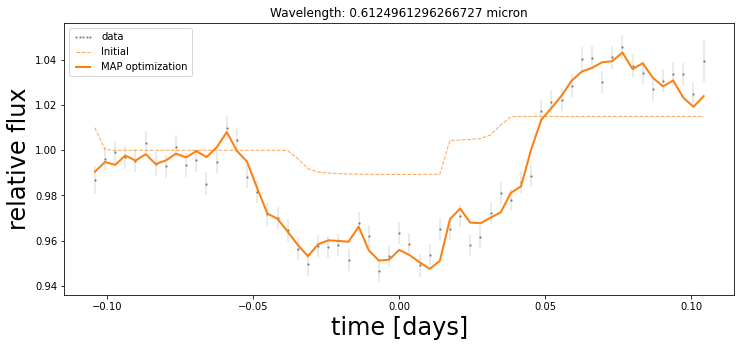

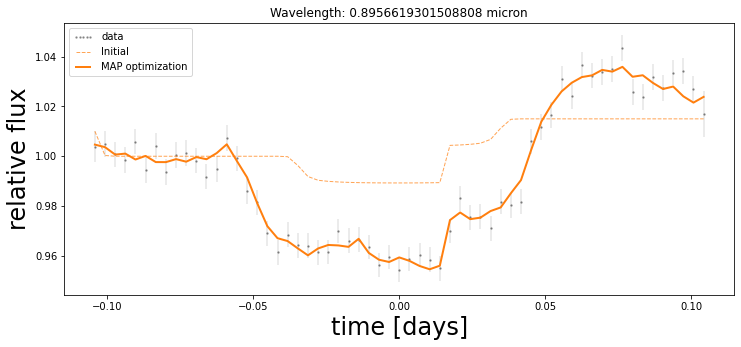

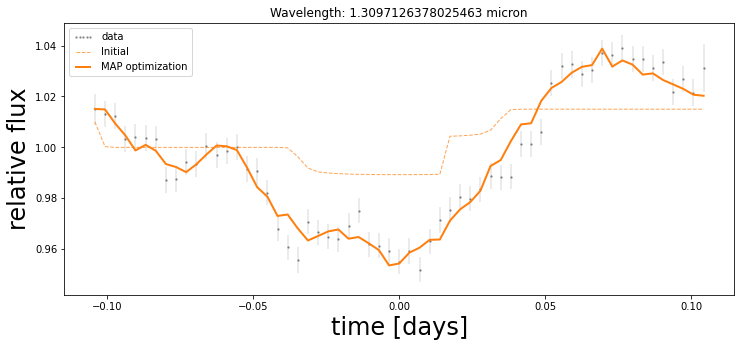

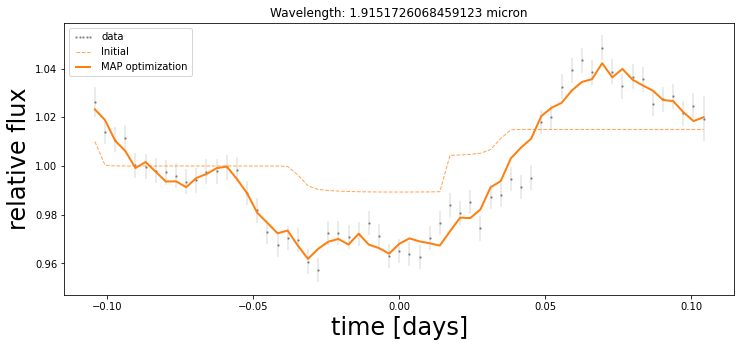

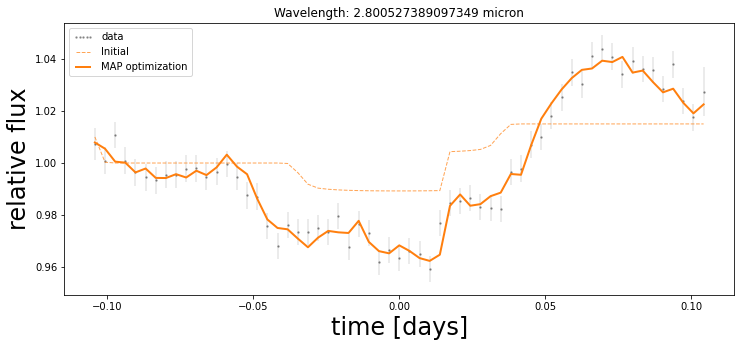

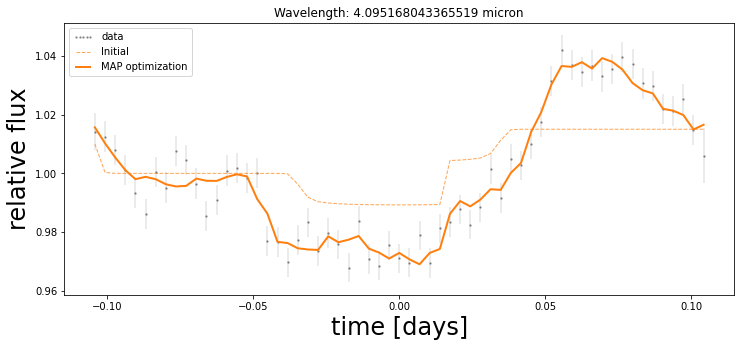

In [16]:
# optimize for initial values!
opt = cmod.optimize(plot=True)

In [17]:
# put those initial values into the sampling and define the number of tuning and draw steps, 
# as well as the number of chains. NOTE: if you do separate wavelength fitting then the number of steps 
# is per wavelengths, not divided between the wavelengths!
cmod.sample(use_optimized_start_point=True, tune=2000, draws=2000, cores=4, chains=4, return_inferencedata=False)

  0%|                                                                                | 0/6 [00:00<?, ?it/s]

Sampling model using the <function sample at 0x28cdf1550> method
Using MAP-optimized start point...


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:510: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [step_t0, step_df, transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch, exponential_decay_time, exponential_A, sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 89 seconds.
The estimated number of effective samples is smaller than 200 for some parameter

                                  mean        sd   hdi_16%   hdi_84%  \
stime_p_1[0]                 -0.000025  0.010204 -0.010069  0.009920   
sx_p_1[0]                    -0.006926  0.001447 -0.008243 -0.005332   
sy_p_1[0]                    -0.004600  0.003342 -0.008271 -0.003906   
sbkg_p_1[0]                   0.007214  0.001372  0.005723  0.008433   
transit_radius_ratio[0]       0.187741  0.009410  0.177661  0.196142   
transit_baseline[0]           0.997214  0.002233  0.994920  0.999377   
exponential_A[0]              0.010563  0.008669  0.002937  0.020279   
exponential_decay_time[0]     0.006557  0.002606  0.005627  0.010000   
transit_epoch[0]              0.000345  0.001246 -0.001008  0.001364   
transit_impact_parameter[0]   0.104396  0.075395  0.000429  0.135088   
transit_stellar_radius[0]     1.180181  0.015916  1.175213  1.199901   
transit_stellar_mass[0]       0.843751  0.037157  0.800033  0.853614   
transit_limb_darkening[0, 0]  0.109329  0.090403  0.000342  0.13

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:510: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [step_t0, step_df, transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch, exponential_decay_time, exponential_A, sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 97 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.

                                  mean        sd   hdi_16%   hdi_84%  \
stime_p_1[0]                  0.000245  0.010029 -0.009631  0.010232   
sx_p_1[0]                    -0.005334  0.001384 -0.006831 -0.004043   
sy_p_1[0]                    -0.003485  0.001436 -0.004873 -0.002102   
sbkg_p_1[0]                   0.005988  0.002279  0.003776  0.008218   
transit_radius_ratio[0]       0.186541  0.007208  0.179754  0.193825   
transit_baseline[0]           0.999861  0.001798  0.998262  1.001810   
exponential_A[0]              0.010513  0.007710  0.003068  0.018168   
exponential_decay_time[0]     0.005667  0.002731  0.004281  0.009993   
transit_epoch[0]             -0.001021  0.000895 -0.001888 -0.000136   
transit_impact_parameter[0]   0.082004  0.059640  0.000014  0.102613   
transit_stellar_radius[0]     1.187172  0.010825  1.184599  1.199999   
transit_stellar_mass[0]       0.827934  0.024192  0.800009  0.833614   
transit_limb_darkening[0, 0]  0.085889  0.074003  0.000132  0.10

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:510: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [step_t0, step_df, transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch, exponential_decay_time, exponential_A, sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 80 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameteriz

                                  mean        sd   hdi_16%   hdi_84%  \
stime_p_1[0]                  0.000067  0.009771 -0.011102  0.008117   
sx_p_1[0]                    -0.006757  0.001315 -0.008192 -0.005630   
sy_p_1[0]                    -0.016672  0.001074 -0.017694 -0.015583   
sbkg_p_1[0]                  -0.008408  0.008206 -0.017620 -0.001270   
transit_radius_ratio[0]       0.155329  0.016303  0.136838  0.168685   
transit_baseline[0]           0.995593  0.001711  0.994145  0.997427   
exponential_A[0]              0.003965  0.006565 -0.002029  0.010756   
exponential_decay_time[0]     0.005131  0.002854  0.001805  0.008382   
transit_epoch[0]             -0.023686  0.001656 -0.025292 -0.022056   
transit_impact_parameter[0]   0.494947  0.221784  0.391194  0.810864   
transit_stellar_radius[0]     1.027077  0.103539  0.948167  1.172708   
transit_stellar_mass[0]       0.988128  0.116868  0.807404  1.063468   
transit_limb_darkening[0, 0]  0.568331  0.280912  0.420152  0.99

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:510: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [step_t0, step_df, transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch, exponential_decay_time, exponential_A, sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 76 seconds.
The number of effective samples is smaller than 10% for some parameters.
 67%|██

                                  mean        sd   hdi_16%   hdi_84%  \
stime_p_1[0]                  0.000181  0.009671 -0.009132  0.010062   
sx_p_1[0]                    -0.009035  0.001386 -0.010589 -0.007895   
sy_p_1[0]                    -0.015415  0.001199 -0.016710 -0.014327   
sbkg_p_1[0]                   0.016435  0.005287  0.011435  0.022068   
transit_radius_ratio[0]       0.162854  0.020535  0.138632  0.178261   
transit_baseline[0]           0.996152  0.001973  0.994930  0.998553   
exponential_A[0]              0.021278  0.006983  0.014597  0.028501   
exponential_decay_time[0]     0.006123  0.002635  0.004856  0.009999   
transit_epoch[0]             -0.028326  0.002083 -0.030109 -0.025949   
transit_impact_parameter[0]   0.647872  0.189572  0.589382  0.867641   
transit_stellar_radius[0]     1.065049  0.104834  1.027342  1.199970   
transit_stellar_mass[0]       0.976259  0.114592  0.800006  1.037608   
transit_limb_darkening[0, 0]  0.562576  0.278892  0.412772  0.99

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:510: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [step_t0, step_df, transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch, exponential_decay_time, exponential_A, sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 64 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.

                                  mean        sd   hdi_16%   hdi_84%  \
stime_p_1[0]                 -0.000001  0.009925 -0.009745  0.009932   
sx_p_1[0]                    -0.007432  0.001447 -0.008915 -0.006024   
sy_p_1[0]                    -0.004986  0.001473 -0.006391 -0.003479   
sbkg_p_1[0]                   0.008110  0.002420  0.005667  0.010513   
transit_radius_ratio[0]       0.149452  0.009617  0.140685  0.159681   
transit_baseline[0]           0.996302  0.002048  0.994231  0.998346   
exponential_A[0]              0.019061  0.007567  0.011668  0.026513   
exponential_decay_time[0]     0.007116  0.002178  0.006441  0.009999   
transit_epoch[0]              0.000466  0.001609 -0.001067  0.002057   
transit_impact_parameter[0]   0.090532  0.065731  0.000021  0.113440   
transit_stellar_radius[0]     1.186747  0.012476  1.184477  1.199992   
transit_stellar_mass[0]       0.828437  0.027964  0.800009  0.832313   
transit_limb_darkening[0, 0]  0.140324  0.117191  0.000008  0.17

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:510: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [step_t0, step_df, transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch, exponential_decay_time, exponential_A, sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 75 seconds.
The number of effective samples is smaller than 25% for some parameters.
100%|██

                                  mean        sd   hdi_16%   hdi_84%  \
stime_p_1[0]                 -0.000253  0.010063 -0.009857  0.009598   
sx_p_1[0]                    -0.010000  0.001432 -0.011417 -0.008628   
sy_p_1[0]                    -0.000489  0.002472 -0.003379  0.001160   
sbkg_p_1[0]                   0.002349  0.008916 -0.006764  0.010517   
transit_radius_ratio[0]       0.161049  0.008984  0.152116  0.169630   
transit_baseline[0]           1.001805  0.001995  0.999583  1.003564   
exponential_A[0]              0.008864  0.006163  0.003619  0.015433   
exponential_decay_time[0]     0.005170  0.002605  0.002452  0.008297   
transit_epoch[0]              0.001049  0.001300 -0.000109  0.002421   
transit_impact_parameter[0]   0.119836  0.084233  0.001428  0.155355   
transit_stellar_radius[0]     1.174712  0.020720  1.168764  1.199979   
transit_stellar_mass[0]       0.862504  0.051045  0.800038  0.876428   
transit_limb_darkening[0, 0]  0.260677  0.180977  0.002815  0.33

100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:20<00:00,  3.50s/it]


At this stage the sampler may print out some warnings that we don't have enough tuning steps! We can then see the results of our sampling by running `.summarize()`

In [21]:
# print out a nice summary table (or list of tables) of our results!
cmod.summary

,mean,sd,hdi_16%,hdi_84%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
stime_p_1[0],-0.000025,0.010204,-0.010069,0.009920,0.000262,0.000185,1524.519609,2157.287277,1.002841
sx_p_1[0],-0.006926,0.001447,-0.008243,-0.005332,0.000046,0.000032,997.268269,1589.297703,1.002362
sy_p_1[0],-0.004600,0.003342,-0.008271,-0.003906,0.000304,0.000216,191.557618,359.292954,1.033342
sbkg_p_1[0],0.007214,0.001372,0.005723,0.008433,0.000037,0.000027,1377.830693,1664.543620,1.003661
transit_radius_ratio[0],0.187741,0.009410,0.177661,0.196142,0.000524,0.000377,336.589279,616.344957,1.014648
...,...,...,...,...,...,...,...,...,...
"transit_limb_darkening[5, 1]",0.307671,0.229361,0.000014,0.388834,0.005436,0.003874,1645.280004,1471.931475,1.001395
transit_a_R*[5],3.409525,0.076314,3.321024,3.472812,0.001627,0.001151,1923.305773,1899.698680,1.002116
transit_planet_radius[5],0.189171,0.010808,0.178331,0.199631,0.000306,0.000217,1241.884552,2160.417460,1.005303
step_df[5],0.013489,0.002549,0.010692,0.015532,0.000069,0.000051,1424.914053,1395.081991,1.001189


An important parameter to look out for here to check whether your samplings have converged is [`r_hat`](https://arviz-devs.github.io/arviz/api/generated/arviz.rhat.html#arviz.rhat). This [rank normalized R-hat diagnostic](https://arxiv.org/abs/1903.08008) tests for lack of convergence by comparing the variance between multiple chains to the variance within each chain. If convergence has been achieved, the between-chain and within-chain variances should be identicalm therefore, the closer it is to 1 the better the chance that your sampling successfully converged. If you're interested in the sampling see the [`PyMC3 docs`](https://docs.pymc.io/en/v3/index.html) for much more detail!

Then we can plot the posterior distributions and check that they look sensible (**but beware** if you've chosen the "separate" optimization method then it will plot the posteriors for every wavelength!):

But what are the results?? We can easily see the results using the handy `.get_results()` function:

In [19]:
results = cmod.get_results(uncertainty=['hdi_16%','hdi_84%'])

# results is a pandas dataframe, however, it doesn't show up properly on Git docs so I'll convert it to an
# astropy table
Table.from_pandas(results)

stime_p_0,stime_p_0_hdi_16%,stime_p_0_hdi_84%,stime_p_1,stime_p_1_hdi_16%,stime_p_1_hdi_84%,wavelength,sx_p_0,sx_p_0_hdi_16%,sx_p_0_hdi_84%,sx_p_1,sx_p_1_hdi_16%,sx_p_1_hdi_84%,sy_p_0,sy_p_0_hdi_16%,sy_p_0_hdi_84%,sy_p_1,sy_p_1_hdi_16%,sy_p_1_hdi_84%,sbkg_p_0,sbkg_p_0_hdi_16%,sbkg_p_0_hdi_84%,sbkg_p_1,sbkg_p_1_hdi_16%,sbkg_p_1_hdi_84%,exponential_A,exponential_A_hdi_16%,exponential_A_hdi_84%,exponential_baseline,exponential_baseline_hdi_16%,exponential_baseline_hdi_84%,exponential_decay_time,exponential_decay_time_hdi_16%,exponential_decay_time_hdi_84%,transit_baseline,transit_baseline_hdi_16%,transit_baseline_hdi_84%,transit_eccentricity,transit_eccentricity_hdi_16%,transit_eccentricity_hdi_84%,transit_epoch,transit_epoch_hdi_16%,transit_epoch_hdi_84%,transit_impact_parameter,transit_impact_parameter_hdi_16%,transit_impact_parameter_hdi_84%,transit_limb_darkening,transit_limb_darkening_hdi_16%,transit_limb_darkening_hdi_84%,transit_omega,transit_omega_hdi_16%,transit_omega_hdi_84%,transit_period,transit_period_hdi_16%,transit_period_hdi_84%,transit_radius_ratio,transit_radius_ratio_hdi_16%,transit_radius_ratio_hdi_84%,transit_stellar_mass,transit_stellar_mass_hdi_16%,transit_stellar_mass_hdi_84%,transit_stellar_radius,transit_stellar_radius_hdi_16%,transit_stellar_radius_hdi_84%,step_df,step_df_hdi_16%,step_df_hdi_84%,step_f0,step_f0_hdi_16%,step_f0_hdi_84%,step_t0,step_t0_hdi_16%,step_t0_hdi_84%
object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object
1.0,1.0,1.0,-2.51e-05,-0.010069,0.0099201,0.6124961296266727 micron,0.0,0.0,0.0,-0.0069258,-0.0082427,-0.0053321,0.0,0.0,0.0,-0.0046,-0.0082705,-0.0039058,0.0,0.0,0.0,0.0072135,0.0057225,0.008433,0.0105626,0.0029369,0.0202786,0,0,0,0.0065575,0.0056268,0.0099997,0.9972137,0.9949202,0.9993772,0.0,0.0,0.0,0.0003454,-0.001008,0.0013642,0.1043958,0.0004292,0.1350883,"[0.1093294, 0.2095252]","[0.0003415, 0.000509]","[0.1319067, 0.2576455]",0,0,0,1,1,1,0.1877411,0.1776613,0.1961417,0.8437511,0.8000325,0.8536144,1.1801812,1.1752135,1.1999008,0.0187796,0.0148887,0.0205809,1,1,1,0.0130766,0.0069463,0.0122986
1.0,1.0,1.0,0.0002448,-0.0096307,0.0102316,0.8956619301508808 micron,0.0,0.0,0.0,-0.005334,-0.0068306,-0.0040426,0.0,0.0,0.0,-0.0034855,-0.0048726,-0.0021022,0.0,0.0,0.0,0.0059878,0.0037759,0.0082175,0.0105134,0.0030682,0.0181683,0,0,0,0.0056671,0.0042814,0.0099932,0.9998615,0.998262,1.0018098,0.0,0.0,0.0,-0.0010209,-0.0018882,-0.0001357,0.0820043,1.36e-05,0.1026128,"[0.0858892, 0.1276669]","[0.0001323, 2.28e-05]","[0.1026429, 0.1561597]",0,0,0,1,1,1,0.1865409,0.1797538,0.1938248,0.827934,0.8000089,0.8336143,1.1871717,1.1845992,1.1999988,0.0173828,0.0153174,0.0197998,1,1,1,0.0159602,0.0145842,0.0172182
1.0,1.0,1.0,6.74e-05,-0.0111021,0.0081172,1.3097126378025463 micron,0.0,0.0,0.0,-0.0067575,-0.0081918,-0.0056298,0.0,0.0,0.0,-0.0166723,-0.0176943,-0.0155827,0.0,0.0,0.0,-0.008408,-0.0176199,-0.0012698,0.0039652,-0.0020291,0.010756,0,0,0,0.0051306,0.0018047,0.0083822,0.995593,0.9941454,0.9974267,0.0,0.0,0.0,-0.0236857,-0.0252922,-0.0220557,0.4949469,0.3911935,0.8108642,"[0.5683313, 0.5599712]","[0.4201522, 0.4053841]","[0.9958447, 0.9996377]",0,0,0,1,1,1,0.1553292,0.1368377,0.1686851,0.9881279,0.8074041,1.0634681,1.0270766,0.9481669,1.1727081,0.0035168,0.0002211,0.0045812,1,1,1,0.011692,0.0066472,0.0174268
1.0,1.0,1.0,0.0001812,-0.0091318,0.0100622,1.9151726068459123 micron,0.0,0.0,0.0,-0.0090349,-0.0105891,-0.0078945,0.0,0.0,0.0,-0.0154153,-0.0167098,-0.0143272,0.0,0.0,0.0,0.0164346,0.0114351,0.0220681,0.0212781,0.0145975,0.028501,0,0,0,0.

We can also make a transmission spectrum table using `.make_transmission_spectrum_table() `

In [24]:
cmod.models['w0']

<chromatic combined model 'combined' 🌈, models: <chromatic polynomial model 'stime' 🌈> * <chromatic polynomial model 'sx' 🌈> + <chromatic polynomial model 'sy' 🌈> + <chromatic polynomial model 'sbkg' 🌈> + <chromatic exponential model 'exponential' 🌈> + <chromatic transit model 'transit' 🌈> * <chromatic step model 'step' 🌈>

In [33]:
def make_transmission_spectrum_table(self, **kw):
    if isinstance(self._og_model, TransitModel):
        return TransitModel.make_transmission_spectrum_table(self, **kw)
    elif isinstance(self._og_model, CombinedModel):
        for mod in self._og_model._chromatic_models.values():
            if isinstance(mod, TransitModel):
                # list_of_spec = self.apply_operation_to_constituent_models(
                #     "make_transmission_spectrum_table"
                # )(**kw)
                list_of_spec = CombinedModel.make_transmission_spectrum_table(self,**kw)
                spec = recombine_spectrum_table(self,list_of_spec, **kw)
                return spec
                # return TransitModel.make_transmission_spectrum_table(**kw)
        warnings.warn(
            f"You cannot make a transmission spectrum table for a non-transit model!"
            f" Your model is: {self._og_model}"
        )
    else:
        warnings.warn(
            f"You cannot make a transmission spectrum table for a non-transit model!"
            f" Your model is: {self._og_model}"
        )

def recombine_spectrum_table(self, list_of_spec, **kw):
    for i, ((name, model), transspec) in enumerate(
        zip(self.models.items(), list_of_spec)
    ):
        if name == "w0":
            spec = transspec.copy()
        else:
            sp = transspec.copy()
            sp.index = [s.replace("0", f"{i}") for s in sp.index.values]
            spec = pd.concat([spec, sp])
    return spec

In [36]:
# this will show errors for the models that aren't transit and return a list!
# transmission_spectrum = cmod.make_transmission_spectrum_table()
transmission_spectrum = make_transmission_spectrum_table(cmod)
# transmission_spectrum
Table.from_pandas(transmission_spectrum)

  0%|                                                                                | 0/6 [00:00<?, ?it/s]/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/transit.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trans_table[f"{self.name}_radius_ratio_neg_error"] = (
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/transit.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trans_table[f"{s

Error applying make_transmission_spectrum_table to <chromatic polynomial model 'stime' 🌈>: 'PolynomialModel' object has no attribute 'make_transmission_spectrum_table'
Error applying make_transmission_spectrum_table to <chromatic polynomial model 'sx' 🌈>: 'PolynomialModel' object has no attribute 'make_transmission_spectrum_table'
Error applying make_transmission_spectrum_table to <chromatic polynomial model 'sy' 🌈>: 'PolynomialModel' object has no attribute 'make_transmission_spectrum_table'
Error applying make_transmission_spectrum_table to <chromatic polynomial model 'sbkg' 🌈>: 'PolynomialModel' object has no attribute 'make_transmission_spectrum_table'
Error applying make_transmission_spectrum_table to <chromatic exponential model 'exponential' 🌈>: 'ExponentialModel' object has no attribute 'make_transmission_spectrum_table'
Error applying make_transmission_spectrum_table to <chromatic step model 'step' 🌈>: 'StepModel' object has no attribute 'make_transmission_spectrum_table'
Erro

wavelength,transit_radius_ratio,transit_radius_ratio_neg_error,transit_radius_ratio_pos_error
object,object,object,object
0.6124961296266727 micron,0.1877411,0.0100798,0.008400600000000008
0.8956619301508808 micron,0.1865409,0.006787100000000018,0.007283899999999982
1.3097126378025463 micron,0.1553292,0.018491499999999994,0.013355900000000004
1.9151726068459123 micron,0.1628542,0.02422260000000001,0.015407299999999985
2.800527389097349 micron,0.1494518,0.008767200000000003,0.010229000000000016
4.095168043365519 micron,0.1610487,0.008932999999999996,0.008581300000000014


In [27]:
for i, ((name, model), transspec) in enumerate(zip(cmod.models.items(),transmission_spectrum)):
    if name == "w0":
        spec = transspec.copy()
    else:
        sp = transspec.copy()
        sp.index = [s.replace("0", f"{i}") for s in sp.index.values]
        spec = pd.concat([spec, sp])

In [28]:
spec

,wavelength,transit_radius_ratio,transit_radius_ratio_neg_error,transit_radius_ratio_pos_error
w0,0.6124961296266727 micron,0.187741,0.01008,0.008401
w1,0.8956619301508808 micron,0.186541,0.006787,0.007284
w2,1.3097126378025463 micron,0.155329,0.018491,0.013356
w3,1.9151726068459123 micron,0.162854,0.024223,0.015407
w4,2.800527389097349 micron,0.149452,0.008767,0.010229
w5,4.095168043365519 micron,0.161049,0.008933,0.008581


We can also create (or call if you set `store_models=True`) the final best-fit models using the `.get_models()` function. This can take a minute if generating the models from parameters for lots of wavelengths.

In [37]:
models = cmod.get_model()
models.keys()

dict_keys(['w0', 'w1', 'w2', 'w3', 'w4', 'w5'])

As the `.get_model()` process can take time to generate the models, we store the models for use later...

In [38]:
cmod._fit_models.keys()

dict_keys(['w0', 'w1', 'w2', 'w3', 'w4', 'w5'])

## Plotting the final results

We have several different methods (mostly wrappers to `chromatic` functions) to plot the modelled results. I'll demonstrate several of them below:

`plot_model()` is an especially useful function for CombinedModels because it allows us to split the model into constituent models and see the relative contribution of each!

In [41]:
def plot_model(self, normalize=True, plot_data=True, wavelength=None, **kw):
    """

    Parameters
    ----------
    normalize: Boolean to normalize all models to mean~1, some models will have default mean~0 (default=True)
    plot_data: Boolean to add real data on top of model plots (default=True)
    kw: Any additional keywords to pass to plot_one_model(), e.g. wavelength, ax

    Returns
    -------

    """
    model = self.get_model()

    def plot_models_for_each_w(ax, mod, name_label, normalize):
        if normalize:
            if np.nanmedian(mod) < 0.1:
                ax.plot(self.data.time, mod + 1, label=f"{name_label}")
            else:
                ax.plot(self.data.time, mod, label=f"{name_label}")
        else:
            ax.plot(self.data.time, mod, label=f"{name_label}")

    def plot_one_model(model, normalize, wavelength, name_label=None, **kw):
        if wavelength is not None:
            try:
                wave_num = []
                model_one_wavelength = {}
                if type(wavelength) == int:
                    i = wavelength
                    wave_num.append(i)
                    if f"w{i}" in model.keys():
                        model_one_wavelength[f"w{i}"] = model[f"w{i}"]
                    else:
                        model_one_wavelength[f"w{i}"] = model["w0"]
                else:
                    for i in wavelength:
                        wave_num.append(i)
                        model_one_wavelength[f"w{i}"] = model[f"w{i}"]
                model = model_one_wavelength
            except:
                return

        else:
            wave_num = range(self.data.nwave)

        if "ax" in kw:
            ax = kw["ax"]
        else:
            if len(wave_num) == 1 or wavelength is not None:
                figsize = (8, 4)
            else:
                figsize = (8, 16)

            if wavelength is not None:
                fi, ax = plt.subplots(
                    nrows=len(wave_num),
                    figsize=figsize,
                    constrained_layout=True,
                )
            else:
                # make sure ax is set up
                fi, ax = plt.subplots(
                    nrows=len(wave_num),
                    figsize=(8, 4),
                    constrained_layout=True,
                )
            if len(wave_num) == 1:
                ax = [ax]
            kw["ax"] = ax

        if name_label is None:
            name_label = self.name

        for wave_n, ax_i, mod in zip(wave_num, ax, model.values()):
            if isinstance(self, CombinedModel):
                list_of_chrom_mods = list(self._chromatic_models.keys())
                list_of_chrom_mods.append("total")
                for chrom_mod in list_of_chrom_mods:
                    plot_models_for_each_w(
                        ax_i, mod[chrom_mod], chrom_mod, normalize
                    )
            else:
                plot_models_for_each_w(ax_i, mod, name_label, normalize)

            if plot_data:
                if wave_n > 0 and self.data.nwave == 1:
                    flux = self.data.flux[0, :]
                    uncertainty = self.data.uncertainty[0, :]
                else:
                    flux = self.data.flux[wave_n, :]
                    uncertainty = self.data.uncertainty[wave_n, :]

                ax_i.plot(self.data.time, flux, "k.")
                ax_i.errorbar(
                    self.data.time,
                    flux,
                    uncertainty,
                    color="k",
                    linestyle="None",
                    capsize=2,
                )
            ax_i.set_title(f"Wavelength {wave_n}")
            ax_i.set_ylabel("Relative Flux")
            ax_i.set_xlabel("Time [d]")
            ax_i.legend()

        return kw

    plot_one_model(model, normalize=normalize, wavelength=wavelength, **kw)

100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 79.37it/s]


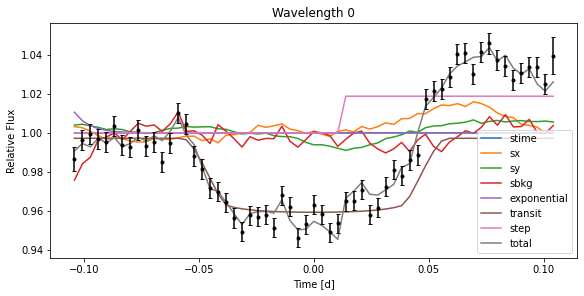

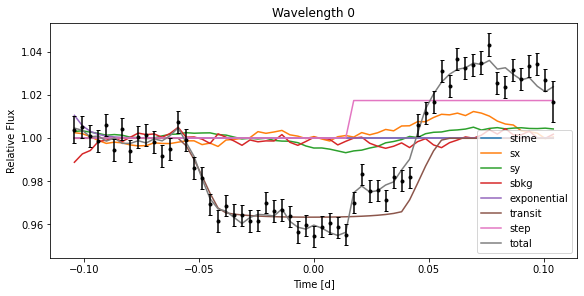

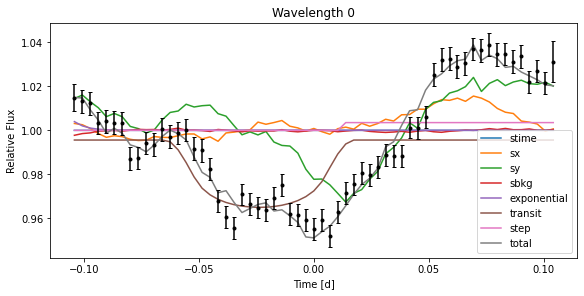

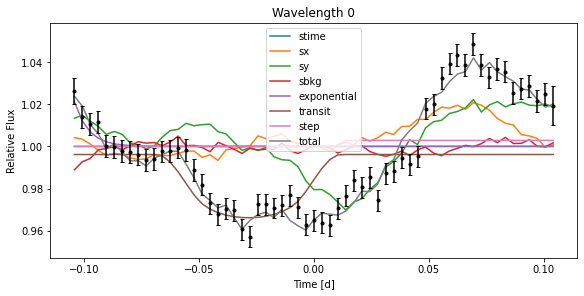

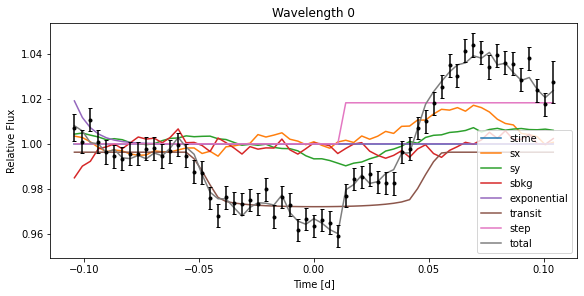

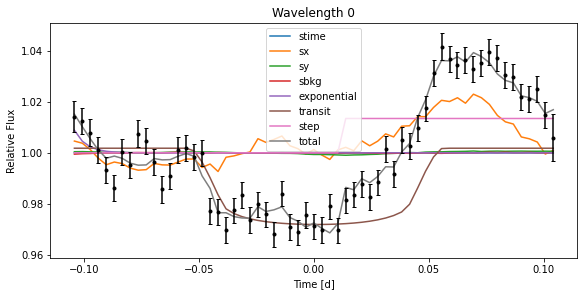

In [44]:
cmod.plot_model()

We can also just choose to see a single model or wavelength:

In [45]:
cmod._chromatic_models['transit'].plot_model(wavelength=1)

/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:1141: UserWarning: You haven't sampled/summarized the model yet!
Either run .summarize() or pass a dictionary of parameters to generate the model.
  warnings.warn(


In [46]:
cmod._chromatic_models['exponential'].plot_model(wavelength=1)

`.plot_lightcurves()` will plot the same lightcurves as before but now with our models on top!

0 dict_keys(['w0', 'w1', 'w2', 'w3', 'w4', 'w5'])


TypeError: unsupported operand type(s) for -: 'dict' and 'float'

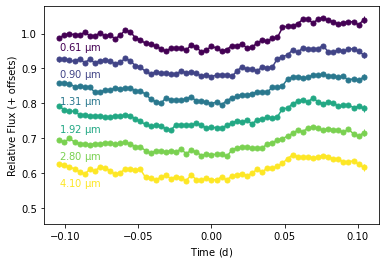

In [52]:
# plot the 2D light curves for each wavelength with the model (black) now overlaid
cmod.plot_lightcurves()

No model attached to data. Running `add_model_to_rainbow` now. You can access this data later using [self].data_with_model


100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.89it/s]


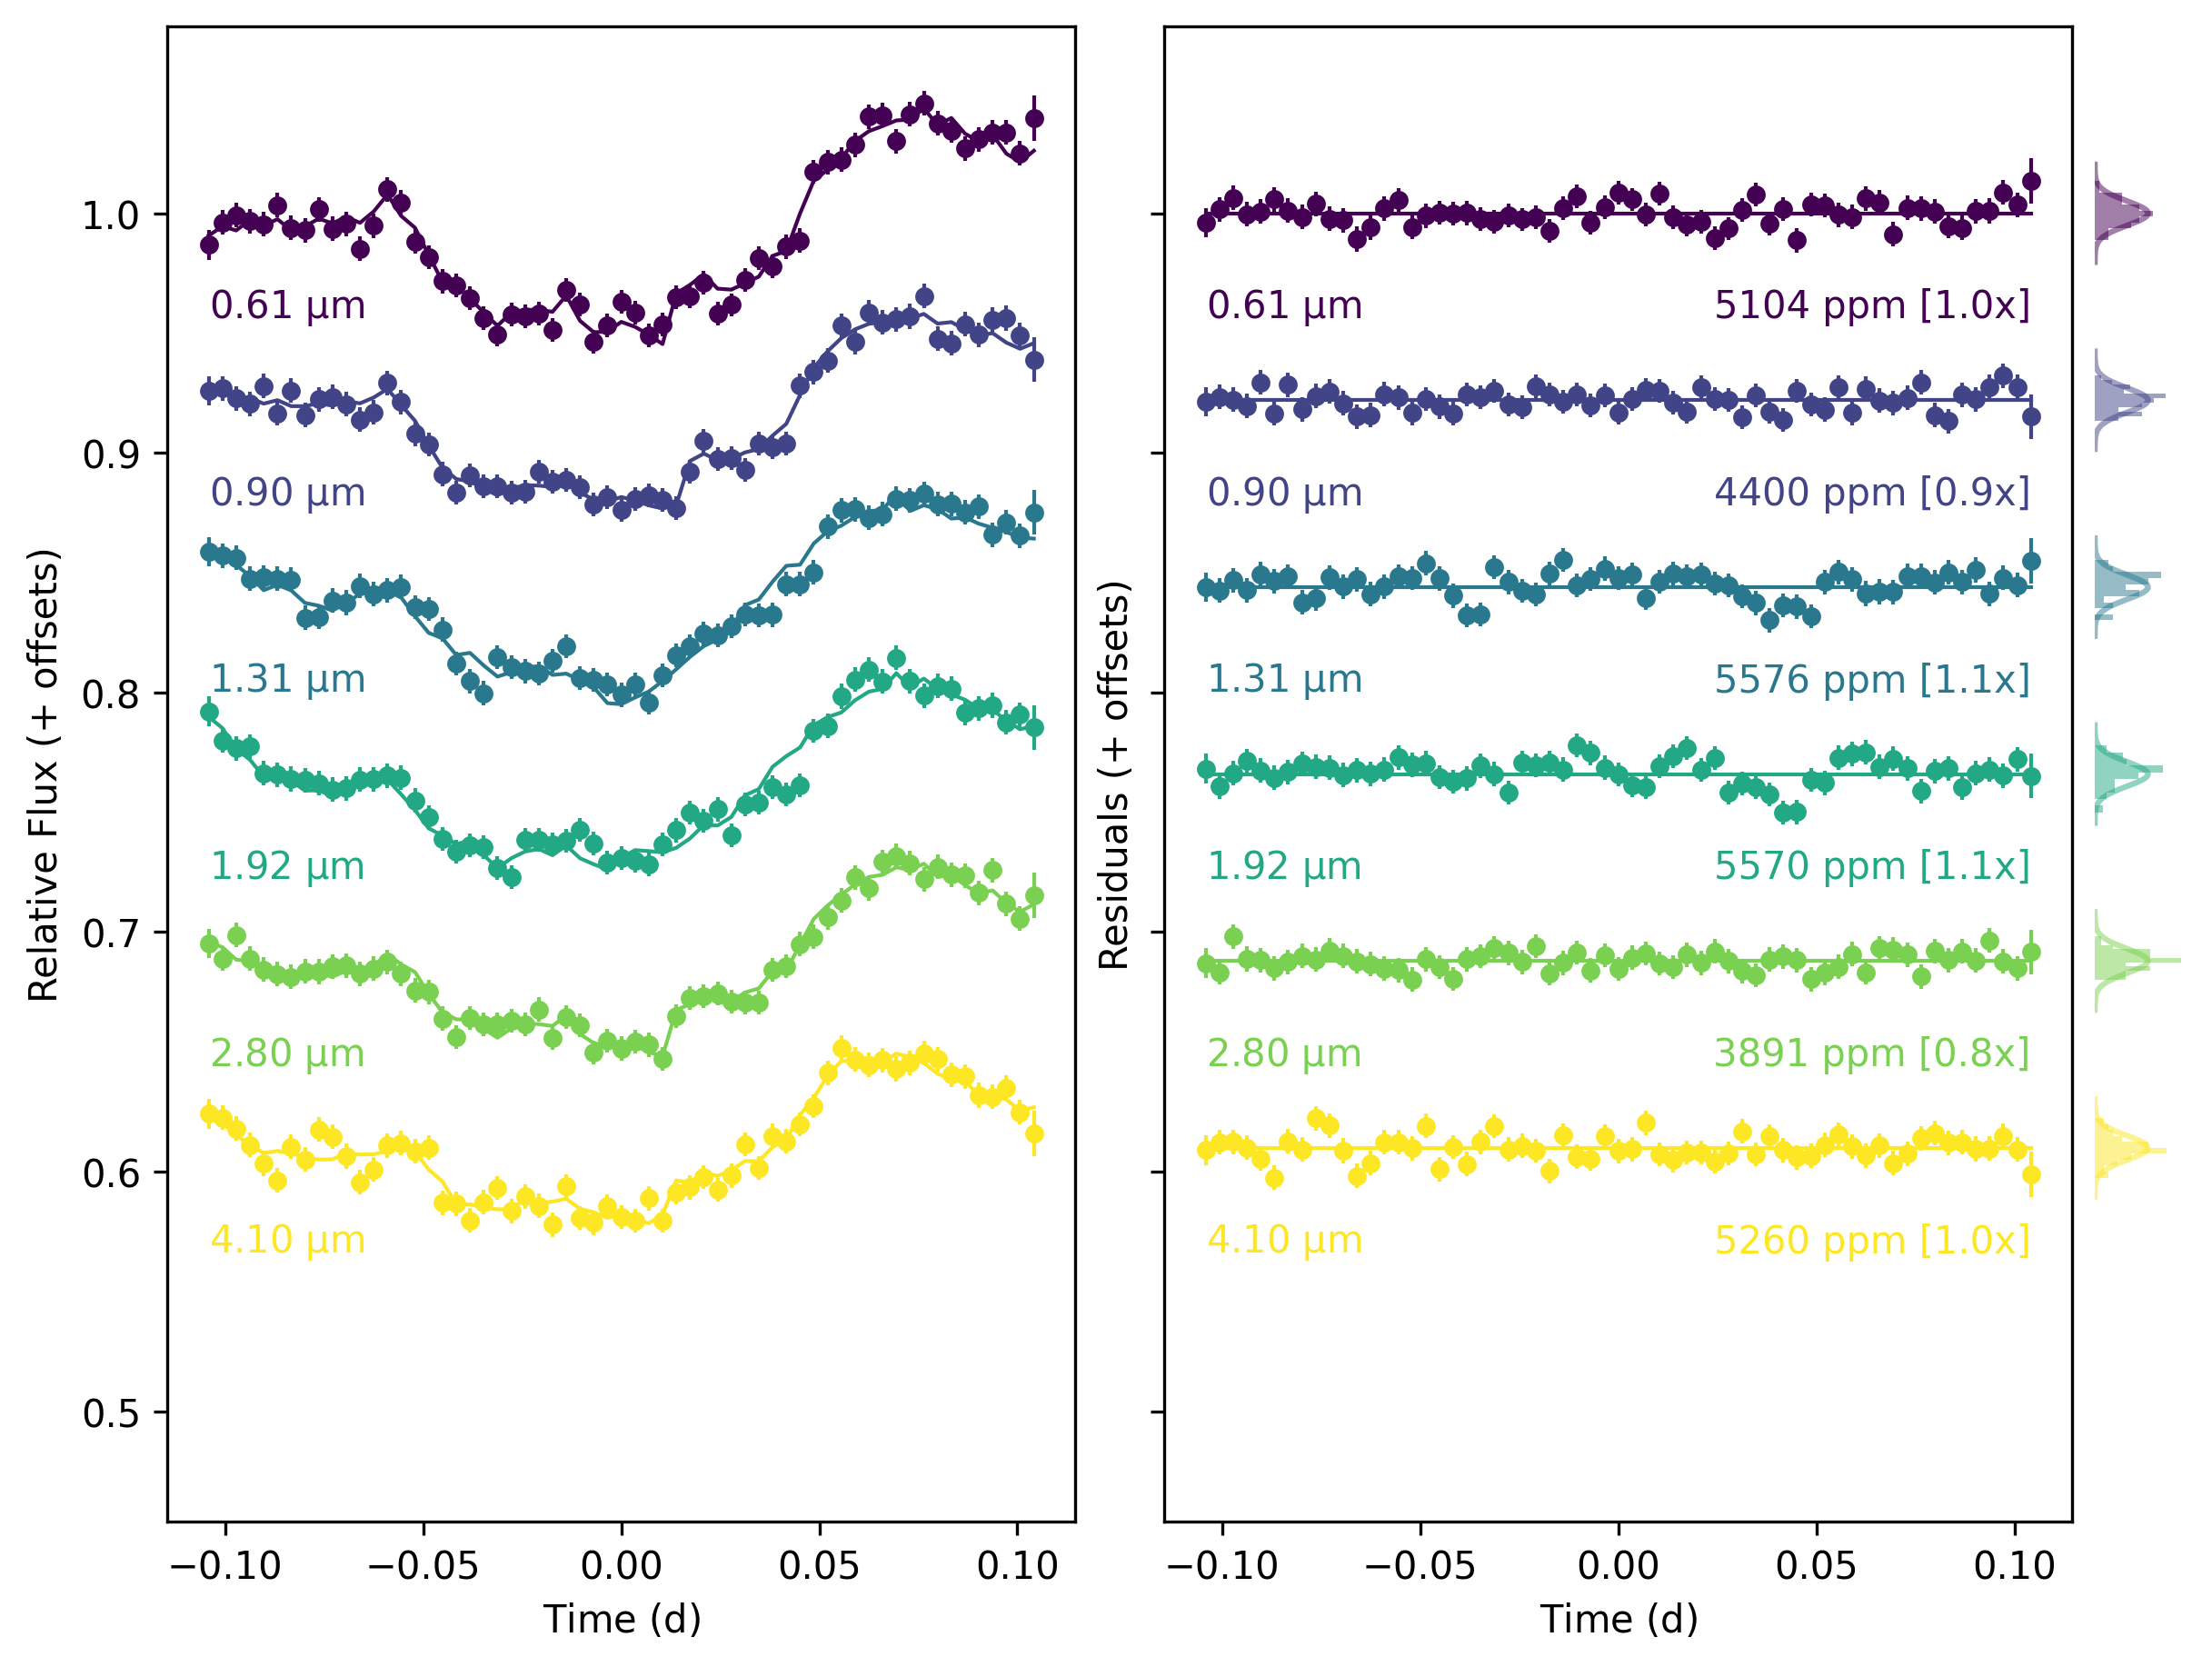

In [50]:
cmod.plot_with_model_and_residuals()

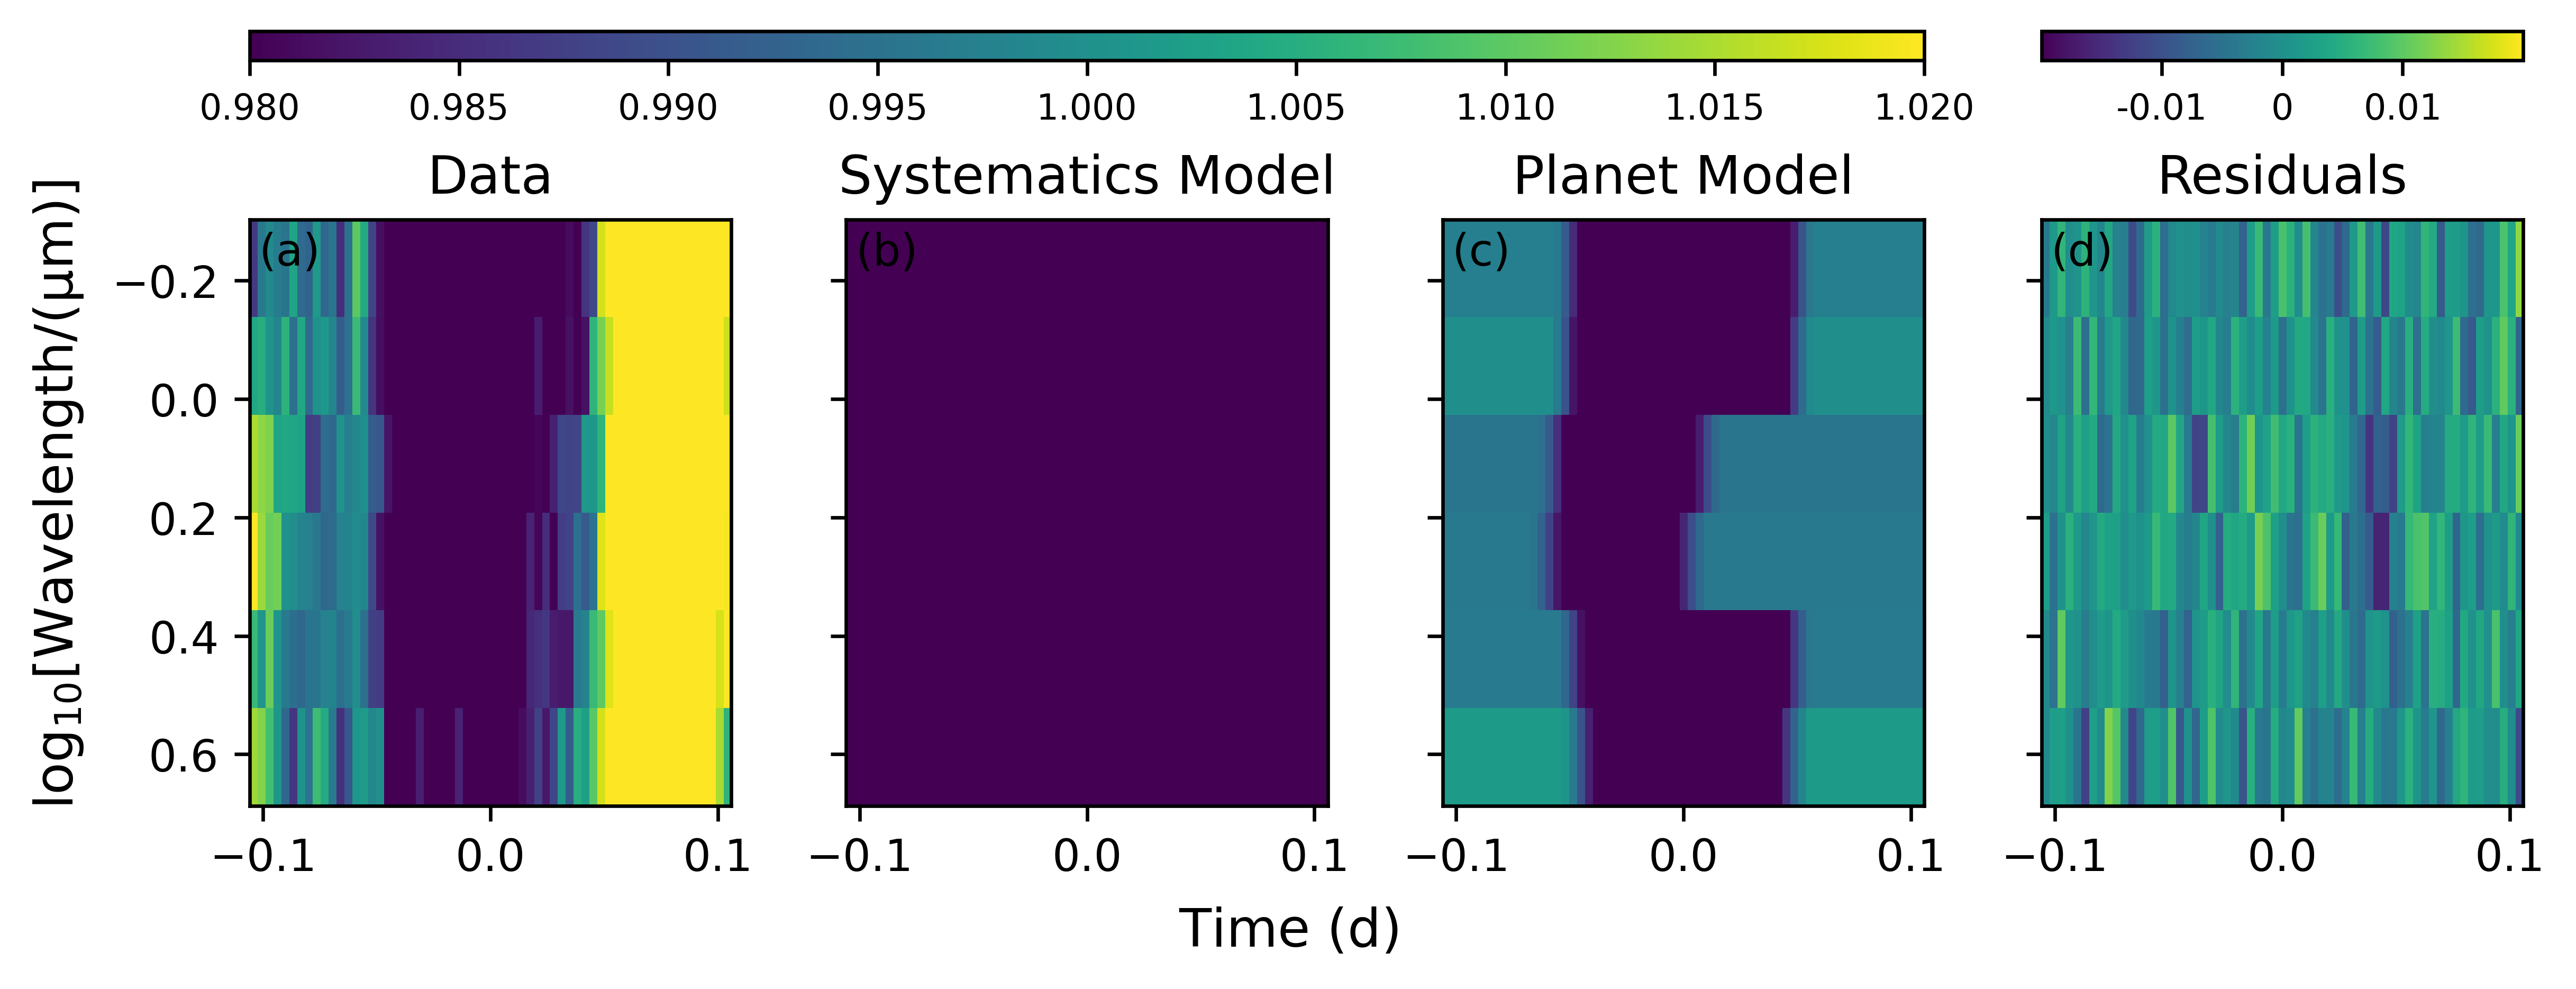

In [51]:
# plot the 3D light curves (flux as a function of time and wavelength) with the residuals
cmod.imshow_with_models()

We can even make gifs to step through each wavelength:

  0%|          | 0/6 [00:00<?, ?it/s]

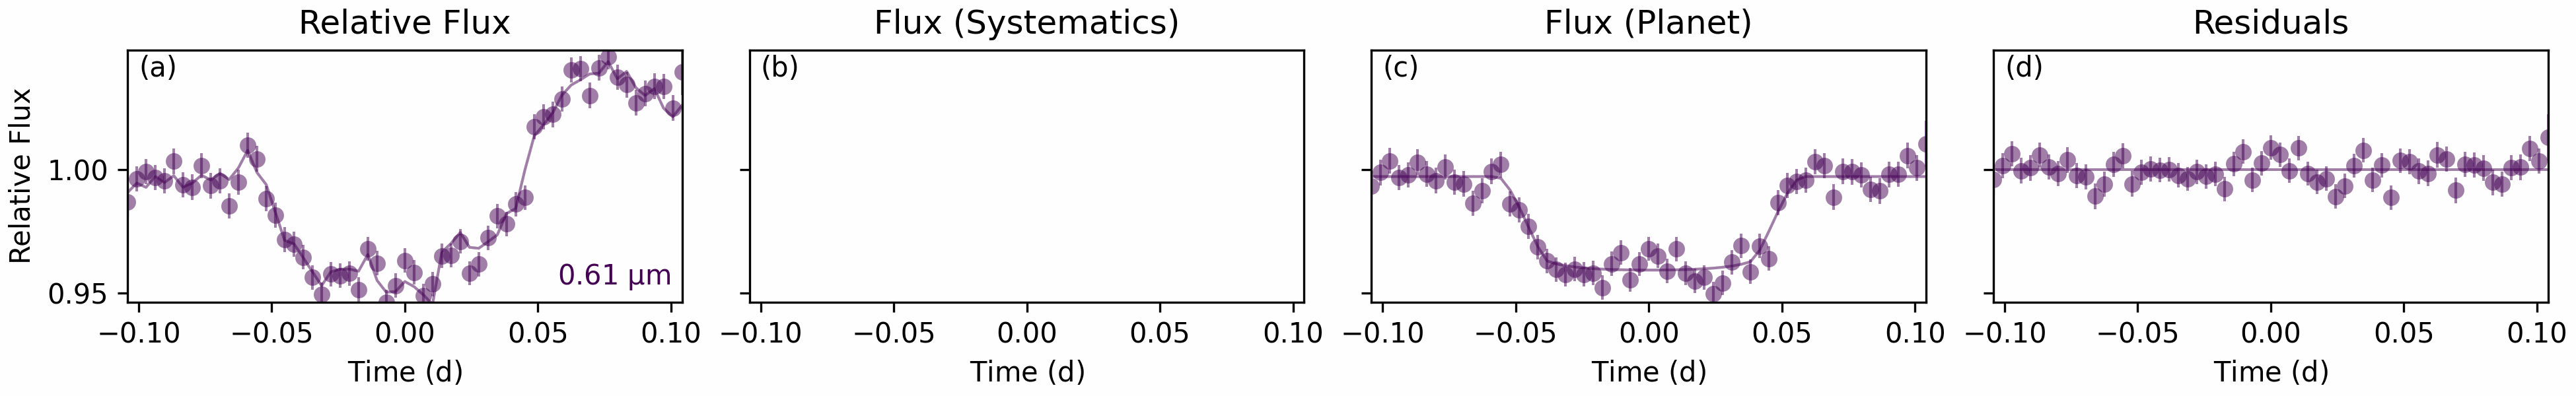

In [53]:
cmod.animate_with_models()#orientation='vertical', panelsize=(7,2))

We can plot the transmission spectrum:

/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:1782: UserWarning: You cannot plot a transmission spectrum table for a non-transit model! Your model is: <chromatic combined model 'combined' 🌈, models: <chromatic polynomial model 'stime' 🌈> * <chromatic polynomial model 'sx' 🌈> + <chromatic polynomial model 'sy' 🌈> + <chromatic polynomial model 'sbkg' 🌈> + <chromatic exponential model 'exponential' 🌈> + <chromatic transit model 'transit' 🌈> * <chromatic step model 'step' 🌈>
  warnings.warn(


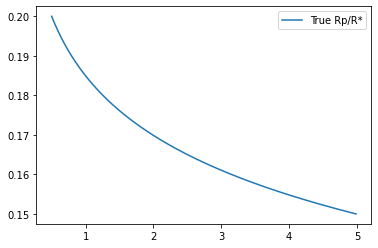

In [55]:
cmod.plot_transmission_spectrum()
plt.plot(SimulatedRainbow().wavelength, np.linspace(0.2, 0.15, SimulatedRainbow().nwave), label="True Rp/R*")
plt.legend();

And assess the quality of our fit with a chi-squared test (with `.chi_squared`):


For Entire Simultaneous Fit:
Fitted Parameters:
 stime_p_1[0], sx_p_1[0], sy_p_1[0], sbkg_p_1[0], transit_radius_ratio[0], transit_baseline[0], exponential_A[0], exponential_decay_time[0], transit_epoch[0], transit_impact_parameter[0], transit_stellar_radius[0], transit_stellar_mass[0], transit_limb_darkening[0, 0], transit_limb_darkening[0, 1], transit_a_R*[0], transit_planet_radius[0], step_df[0], step_t0[0], stime_p_1[1], sx_p_1[1], sy_p_1[1], sbkg_p_1[1], transit_radius_ratio[1], transit_baseline[1], exponential_A[1], exponential_decay_time[1], transit_epoch[1], transit_impact_parameter[1], transit_stellar_radius[1], transit_stellar_mass[1], transit_limb_darkening[1, 0], transit_limb_darkening[1, 1], transit_a_R*[1], transit_planet_radius[1], step_df[1], step_t0[1], stime_p_1[2], sx_p_1[2], sy_p_1[2], sbkg_p_1[2], transit_radius_ratio[2], transit_baseline[2], exponential_A[2], exponential_decay_time[2], transit_epoch[2], transit_impact_parameter[2], transit_stellar_radius[2], tran

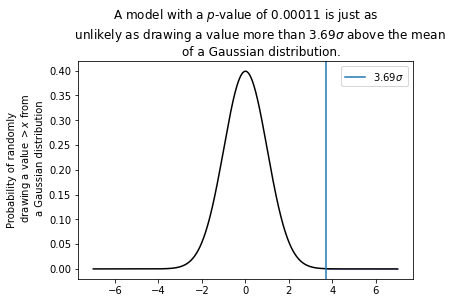

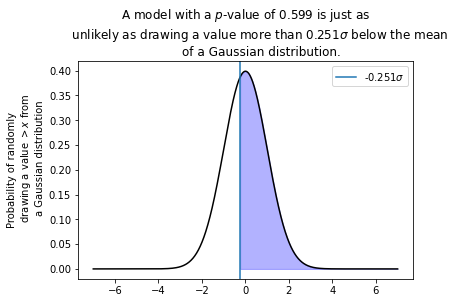

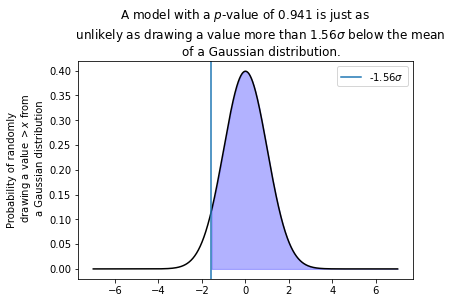

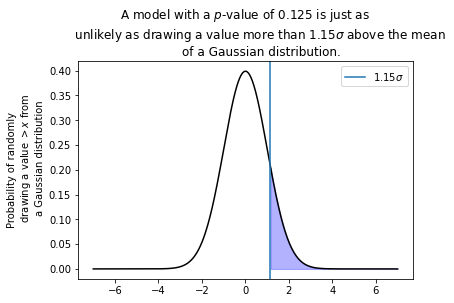

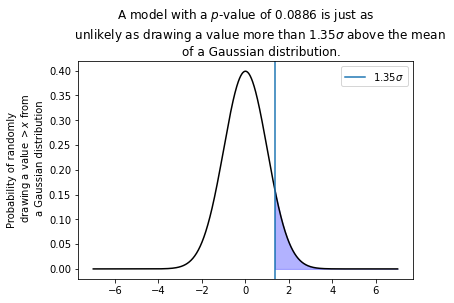

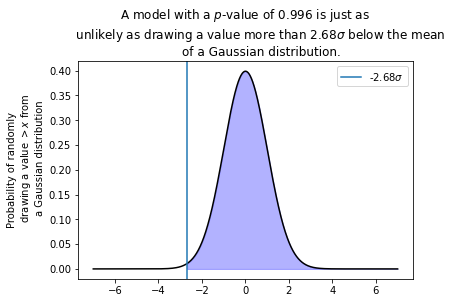

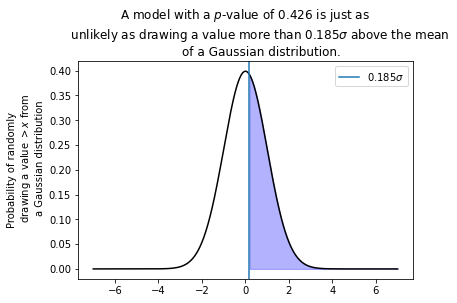

In [62]:
cmod.chi_squared(plot=True, individual_wavelengths=True)

For the Wavelength-Averaged Residuals...


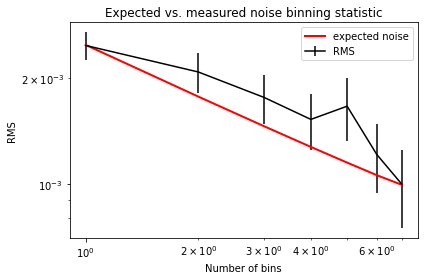

Calculated white noise: 0.0022248 

        Calculated red noise: 0.0011192 

        Calculated beta: 1.8606


In [61]:
cmod.residual_noise_calculator()